In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
EXCEL_PATH =  '/content/drive/MyDrive/Хакатон/Датасет_Посуточная_ведомость_водосчетчика_ХВС_ИТП.xlsx'

Mounted at /content/drive


In [ ]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

SEQ_LEN = 8         # длина входной последовательности (8 часов)
HORIZON = 24        # горизонт прогноза (24 часа)
VAL_PATIENCE = 10   # patience для EarlyStopping
MAX_EPOCHS = 120    # верхний лимит эпох (ранняя остановка сократит)

In [ ]:
def parse_hour(x):
    """Преобразуем час:
       - если число/строка числа -> int 0..23
       - если 'H1-H2' -> берём левую границу H1
    """
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)) and not isinstance(x, bool):
        return int(x)
    s = str(x).strip()
    if '-' in s:
        left = s.split('-')[0].strip()
        return int(left)
    return int(s)

In [ ]:
def make_sequences(df_norm, seq_len=SEQ_LEN, horizon=HORIZON):
    """Создаём выборки: X (n, seq_len, 3), Y (n, horizon) — прогноз cons."""
    arr = df_norm[['day', 'hour', 'cons']].to_numpy()
    X, Y = [], []
    for i in range(len(arr) - seq_len - horizon + 1):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + seq_len : i + seq_len + horizon, 2]  # только cons
        X.append(x_i); Y.append(y_i)
    return np.asarray(X, dtype=np.float32), np.asarray(Y, dtype=np.float32)

In [ ]:
def build_model(input_shape, conv_filters=32, conv_kernel=3, lstm1=64, lstm2=32, dropout=0.0):
    """Conv1D -> LSTM -> LSTM -> Dense(24)."""
    m = models.Sequential()
    # Свёртка по времени (каузальная) — помогает вытащить локальные паттерны
    m.add(layers.Conv1D(filters=conv_filters,
                        kernel_size=conv_kernel,
                        padding='causal',
                        activation='relu',
                        input_shape=input_shape))
    # Рекуррентная часть
    m.add(layers.LSTM(lstm1, return_sequences=True))
    if dropout > 0:
        m.add(layers.Dropout(dropout))
    m.add(layers.LSTM(lstm2, return_sequences=False))
    # Выход: 24 значения вперёд
    m.add(layers.Dense(HORIZON))
    # m.compile(optimizer='adam', loss='mse', metrics=['mse'])
    m.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    return m

In [ ]:
def plot_history(history):
    import matplotlib.pyplot as plt
    # MSE
    plt.figure(figsize=(7,4))
    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Val MSE')
    plt.xlabel('Эпоха'); plt.ylabel('MSE'); plt.title('История обучения (MSE)')
    plt.legend(); plt.tight_layout(); plt.show()

    # MAE
    if 'mae' in history.history and 'val_mae' in history.history:
        plt.figure(figsize=(7,4))
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Val MAE')
        plt.xlabel('Эпоха'); plt.ylabel('MAE'); plt.title('История обучения (MAE)')
        plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
def inverse_scale(y_scaled, cons_min, cons_max, eps=1e-9):
    return y_scaled * max(cons_max - cons_min, eps) + cons_min

In [ ]:
df = pd.read_excel(EXCEL_PATH)

df = df.iloc[:, [0, 1, 3]].copy()
df.columns = ['date_raw', 'hour_raw', 'consumption']

# Дата -> datetime
df['date'] = pd.to_datetime(df['date_raw'], dayfirst=True, errors='coerce')

# Чистка NaN
df = df.dropna(subset=['date', 'consumption']).reset_index(drop=True)

df['day_index'] = (df['date'] - df['date'].min()).dt.days

# Час
df['hour'] = df['hour_raw'].apply(parse_hour)
df = df[(df['hour'] >= 0) & (df['hour'] <= 23)].copy()

# Оставляем только нужные признаки
data = df[['day_index', 'hour', 'consumption']].copy()

In [ ]:
# Хронологическое разбиение по дням: 70% / 15% / 15%
unique_days = np.sort(data['day_index'].unique())
n_days = len(unique_days)
if n_days < 5:
    raise ValueError("Слишком мало уникальных дней для корректного разбиения (нужно ≥ 5).")

n_train = int(n_days * 0.70)
n_val   = int(n_days * 0.15)
n_test  = n_days - n_train - n_val
if n_test == 0:
    n_test = 1
    n_val = max(1, n_val - 1)

days_train = unique_days[:n_train]
days_val   = unique_days[n_train:n_train+n_val]
days_test  = unique_days[n_train+n_val:]

train_df = data[data['day_index'].isin(days_train)].copy()
val_df   = data[data['day_index'].isin(days_val)].copy()
test_df  = data[data['day_index'].isin(days_test)].copy()

In [ ]:
# Масштабирование
max_day_train = max(1, train_df['day_index'].max())  # защита от деления на 0
cons_min = train_df['consumption'].min()
cons_max = train_df['consumption'].max()
eps = 1e-9

def scale_block(df_block):
    return pd.DataFrame({
        'day':  df_block['day_index'] / max_day_train,
        'hour': df_block['hour'] / 23.0,
        'cons': (df_block['consumption'] - cons_min) / max(cons_max - cons_min, eps)
    })

train_norm = scale_block(train_df)
val_norm   = scale_block(val_df)
test_norm  = scale_block(test_df)

In [ ]:
# 6) Формируем выборки для 8->24
X_train, Y_train = make_sequences(train_norm, SEQ_LEN, HORIZON)
X_val,   Y_val   = make_sequences(val_norm,   SEQ_LEN, HORIZON)
X_test,  Y_test  = make_sequences(test_norm,  SEQ_LEN, HORIZON)

print("Shapes:")
print("  X_train:", X_train.shape, " Y_train:", Y_train.shape)
print("  X_val:  ", X_val.shape,   " Y_val:  ", Y_val.shape)
print("  X_test: ", X_test.shape,  " Y_test: ", Y_test.shape)

if min(len(X_train), len(X_val), len(X_test)) == 0:
    raise ValueError("После формирования окон одна из выборок пуста. "
                     "Убедись, что данных достаточно для SEQ_LEN=8 и HORIZON=24 в каждом сплите.")

Shapes:
  X_train: (473, 8, 3)  Y_train: (473, 24)
  X_val:   (65, 8, 3)  Y_val:   (65, 24)
  X_test:  (89, 8, 3)  Y_test:  (89, 24)


In [ ]:
# 7) Подбор гиперпараметров
search_space = [
    dict(conv_filters=32, conv_kernel=3, lstm1=64, lstm2=32, dropout=0.0),
    dict(conv_filters=32, conv_kernel=5, lstm1=64, lstm2=32, dropout=0.0),
    dict(conv_filters=48, conv_kernel=3, lstm1=96, lstm2=48, dropout=0.1),
    dict(conv_filters=64, conv_kernel=3, lstm1=64, lstm2=32, dropout=0.1),
]

best_cfg = None
best_val = np.inf
best_history = None
best_model = None

for i, cfg in enumerate(search_space, 1):
    print(f"\n>>> Конфигурация {i}/{len(search_space)}: {cfg}")
    tf.keras.backend.clear_session()
    model = build_model(
        input_shape=(SEQ_LEN, 3),
        conv_filters=cfg['conv_filters'],
        conv_kernel=cfg['conv_kernel'],
        lstm1=cfg['lstm1'],
        lstm2=cfg['lstm2'],
        dropout=cfg['dropout']
    )
    es = callbacks.EarlyStopping(monitor='val_loss', patience=VAL_PATIENCE, restore_best_weights=True, verbose=1)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=MAX_EPOCHS,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )
    val_mse = min(history.history['val_mse'])
    print(f" val_mse(best): {val_mse:.6f}")
    if val_mse < best_val:
        best_val = val_mse
        best_cfg = cfg
        best_history = history
        best_model = model

print("\nЛучшая конфигурация:", best_cfg, f"(val_mse={best_val:.6f})")


>>> Конфигурация 1/4: {'conv_filters': 32, 'conv_kernel': 3, 'lstm1': 64, 'lstm2': 32, 'dropout': 0.0}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 94: early stopping
Restoring model weights from the end of the best epoch: 84.
 val_mse(best): 0.007072

>>> Конфигурация 2/4: {'conv_filters': 32, 'conv_kernel': 5, 'lstm1': 64, 'lstm2': 32, 'dropout': 0.0}
Restoring model weights from the end of the best epoch: 119.
 val_mse(best): 0.006385

>>> Конфигурация 3/4: {'conv_filters': 48, 'conv_kernel': 3, 'lstm1': 96, 'lstm2': 48, 'dropout': 0.1}
Restoring model weights from the end of the best epoch: 119.
 val_mse(best): 0.004985

>>> Конфигурация 4/4: {'conv_filters': 64, 'conv_kernel': 3, 'lstm1': 64, 'lstm2': 32, 'dropout': 0.1}
Restoring model weights from the end of the best epoch: 120.
 val_mse(best): 0.005833

Лучшая конфигурация: {'conv_filters': 48, 'conv_kernel': 3, 'lstm1': 96, 'lstm2': 48, 'dropout': 0.1} (val_mse=0.004985)


Тестовые метрики -> MSE: 0.004621 | MAE: 0.050459


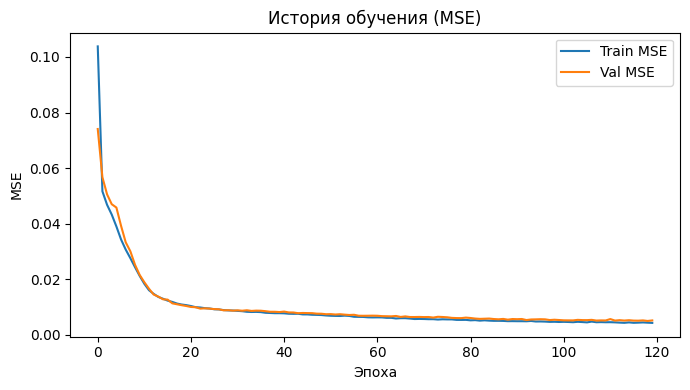

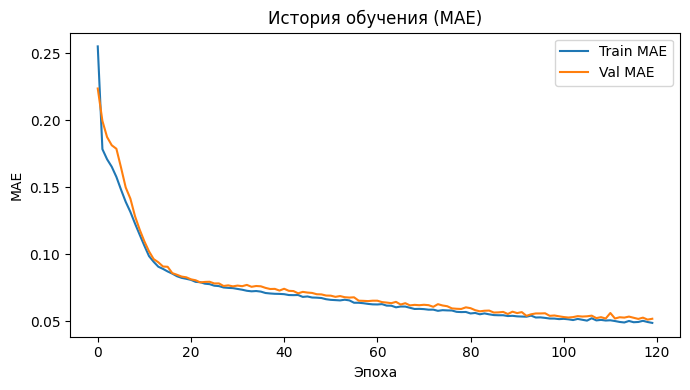

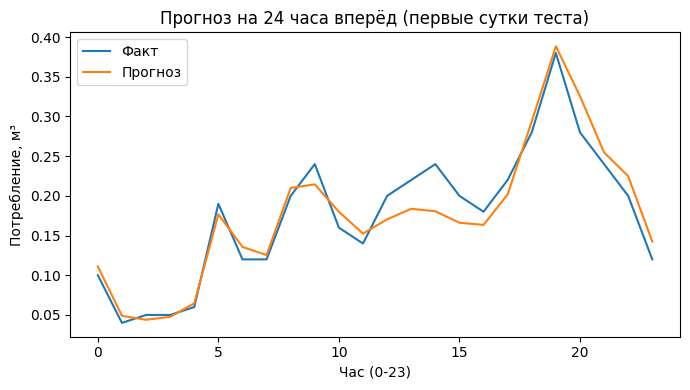

In [ ]:
# 8) Обучение на лучшей конфигурации
# Оценка на тестовых данных
test_metrics = best_model.evaluate(X_test, Y_test, verbose=0)
# Порядок метрик соответствует compile: [loss, mse, mae]
test_loss, test_mse, test_mae = test_metrics
print(f"Тестовые метрики -> MSE: {test_mse:.6f} | MAE: {test_mae:.6f}")

# 9) Графики: кривая обучения и прогноз vs факт
plot_history(best_history)

# Сформируем прогноз на ПЕРВЫЕ 24 часа теста, взяв контекст из последних 8 часов ВАЛИДАЦИИ
if len(val_norm) >= SEQ_LEN:
    x0 = val_norm.tail(SEQ_LEN)[['day','hour','cons']].to_numpy().reshape(1, SEQ_LEN, 3).astype(np.float32)
    y_pred_scaled = best_model.predict(x0, verbose=0).reshape(-1)
    y_pred = inverse_scale(y_pred_scaled, cons_min, cons_max)

    # Фактические 24 часа из теста
    true_24 = test_df['consumption'].iloc[:HORIZON].to_numpy()
    hours = np.arange(HORIZON)

    plt.figure(figsize=(7,4))
    plt.plot(hours, true_24, label='Факт')
    plt.plot(hours, y_pred, label='Прогноз')
    plt.xlabel('Час (0-23)'); plt.ylabel('Потребление, м³')
    plt.title('Прогноз на 24 часа вперёд (первые сутки теста)')
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("Недостаточно валид. данных для построения демонстрационного прогноза с контекстом 8 часов.")

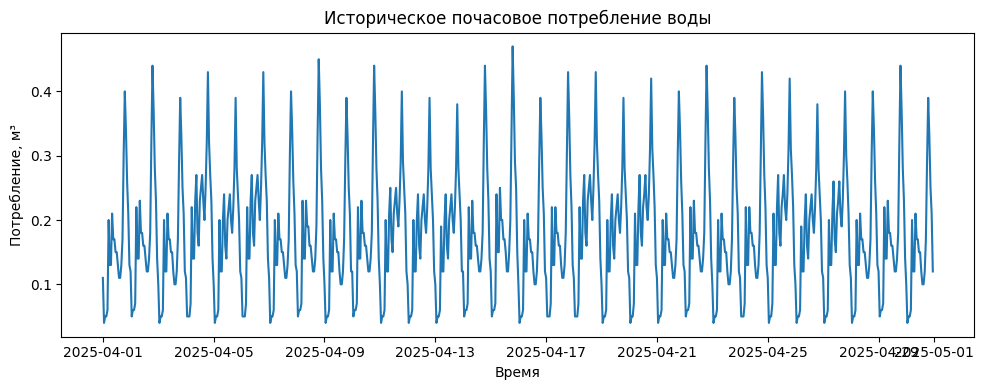

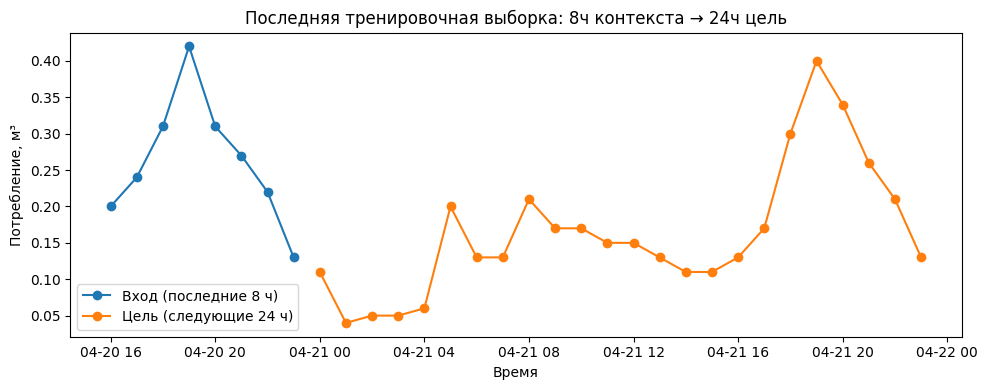

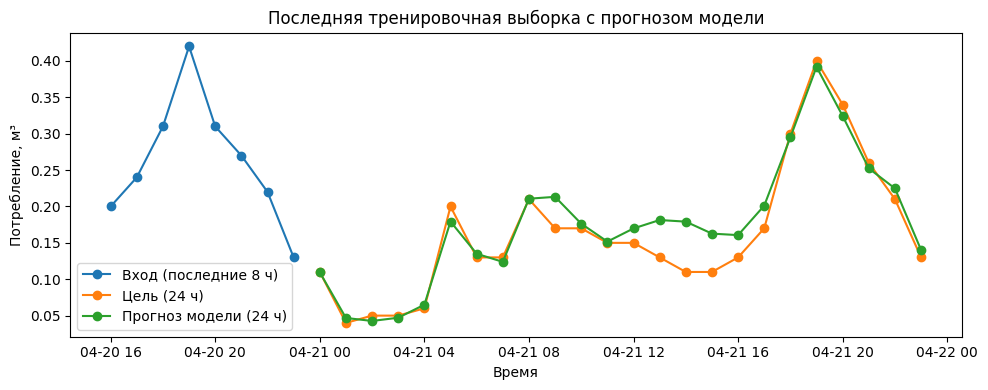

In [ ]:

df_all = df.copy()
df_all['ts'] = df_all['date'].dt.normalize() + pd.to_timedelta(df_all['hour'], unit='h')

# --- График исторических данных (весь датасет) ---
plt.figure(figsize=(10,4))
plt.plot(df_all['ts'], df_all['consumption'])
plt.xlabel('Время'); plt.ylabel('Потребление, м³')
plt.title('Историческое почасовое потребление воды')
plt.tight_layout(); plt.show()

# 2) Последняя тренировочная выборка (последнее окно 8->24 из train_df)
# Для аккуратного сопоставления индексов убедимся, что train_df отсортирован так же:
train_df_sorted = train_df.sort_values(['day_index','hour']).reset_index(drop=True)

i0 = len(train_df_sorted) - (SEQ_LEN + HORIZON)  # старт последнего окна в трейне
if i0 < 0:
    raise ValueError("Недостаточно данных в train для окна SEQ_LEN+HORIZON.")

ctx = train_df_sorted.iloc[i0 : i0 + SEQ_LEN].copy()                    # 8 часов — вход
fut = train_df_sorted.iloc[i0 + SEQ_LEN : i0 + SEQ_LEN + HORIZON].copy()# 24 часа — цель

# Сформируем временную метку и для train_df (на случай если её ещё нет)
ctx['ts'] = (df['date'].dt.normalize().min() +
             pd.to_timedelta(ctx['day_index'], unit='D') +
             pd.to_timedelta(ctx['hour'], unit='h'))
fut['ts'] = (df['date'].dt.normalize().min() +
             pd.to_timedelta(fut['day_index'], unit='D') +
             pd.to_timedelta(fut['hour'], unit='h'))

# --- График «последняя тренировочная выборка»: контекст 8ч и цель 24ч ---
plt.figure(figsize=(10,4))
plt.plot(ctx['ts'], ctx['consumption'], marker='o', label='Вход (последние 8 ч)')
plt.plot(fut['ts'], fut['consumption'], marker='o', label='Цель (следующие 24 ч)')
plt.xlabel('Время'); plt.ylabel('Потребление, м³')
plt.title('Последняя тренировочная выборка: 8ч контекста → 24ч цель')
plt.legend(); plt.tight_layout(); plt.show()

# 3) (Опционально) Добавить прогноз модели для этой выборки на график выше
# Требуется: best_model, train_norm, cons_min, cons_max, SEQ_LEN, HORIZON
try:
    # Возьмём соответствующий фрагмент НОРМАЛИЗОВАННЫХ данных для входа модели
    # Индекс в нормализованном train_norm совпадает с train_df_sorted, если ты делал их без пересортировок
    x_last = train_norm[['day','hour','cons']].iloc[i0 : i0 + SEQ_LEN].to_numpy().reshape(1, SEQ_LEN, 3).astype(np.float32)

    # Прогноз (нормализованный) и обратное масштабирование в м³
    y_pred_scaled = best_model.predict(x_last, verbose=0).reshape(-1)
    y_pred = y_pred_scaled * max(cons_max - cons_min, 1e-9) + cons_min

    plt.figure(figsize=(10,4))
    # Повторим факт
    plt.plot(ctx['ts'], ctx['consumption'], marker='o', label='Вход (последние 8 ч)')
    plt.plot(fut['ts'], fut['consumption'], marker='o', label='Цель (24 ч)')
    # Прогноз
    plt.plot(fut['ts'], y_pred, marker='o', label='Прогноз модели (24 ч)')
    plt.xlabel('Время'); plt.ylabel('Потребление, м³')
    plt.title('Последняя тренировочная выборка с прогнозом модели')
    plt.legend(); plt.tight_layout(); plt.show()
except Exception as e:
    print("Прогноз не добавлен (возможно, нет best_model/train_norm или размеры не совпали):", e)